In [1]:
import subprocess
import fnmatch
from pathlib import Path

import geowombat as gw
from geowombat.util import GeoDownloads
from geowombat.radiometry import BRDF, RadTransforms, landsat_pixel_angles
from geowombat.data import rgbn

import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from tqdm import tqdm

/Users/Admin/Documents/jordan/scripts/Python/venvs/ts3/lib/python3.7/site-packages/distributed-2.6.0-py3.7.egg/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 51] Network is unreachable
  RuntimeWarning,


In [2]:
import os
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

In [ ]:
gdl = GeoDownloads()

gdl.download_cube(['l7'], 
                  ['2010-01-01', '2010-02-01'],
                  (-91.57, 40.37, -91.46, 40.42),
                  ['B8'],
                  crs={'init': 'epsg:4326'})

> /Users/Admin/Documents/jordan/scripts/Python/venvs/ts3/lib/python3.7/site-packages/GeoWombat-1.0.0b0-py3.7-macosx-10.14-x86_64.egg/geowombat/util/web.py(192)download_cube()
    191 
--> 192                         self.list_gcp(sensor, query)
    193 



ipdb>  locations


['025/032', '024/032']


ipdb>  query


'025/032/*025032_201001*_T*'


ipdb>  yearmonth_query


'201001'


ipdb>  month_range


[1, 2]


ipdb>  year


2010


ipdb>  self.list_gcp(sensor, query)
ipdb>  del_keys = [k for k, v in self.search_dict.items() if 'gap_mask' in k]
ipdb>  for dk in del_keys: del self.search_dict[dk]
ipdb>  list(self.search_dict.keys())


*** Error in argument: '(self.search_dict.keys())'


ipdb>  print(list(self.search_dict.keys()))


['LE07/01/025/032/LE07_L1GT_025032_20100121_20160916_01_T2', 'LE07/01/025/032/LE07_L1TP_025032_20100105_20160916_01_T2']


ipdb>  bands


['B8']


ipdb>  search_wildcards = ['ANG.txt', 'MTL.txt'] + [bd + '.TIF' for bd in bands]
ipdb>  search_wildcards


['ANG.txt', 'MTL.txt', 'B8.TIF']


ipdb>  crs


{'init': 'epsg:4326'}


ipdb>  bounds


   0                                           geometry
0  0  POLYGON ((-91.57000 40.42000, -91.46000 40.420...


In [5]:
data_bin = os.path.realpath(os.path.dirname('/Users/Admin/Documents/jordan/scripts/Python/geowombat/geowombat/util/web.py'))
wrs = Path(data_bin).joinpath('../data/wrs2_descending.shp')

In [6]:
df = gpd.read_file(wrs)

In [7]:
def intersect_geometry(dfa, dfb):
    
    """
    Gets all possible intersections between two geometries
    """
    
    int_geoms = list()
    
    for i in range(0, dfa.shape[0]):
        
        geoma = dfa.iloc[i].geometry
        
        geomb = dfb.iloc[i].geometry

        if geomb:
            int_geoms.append(geoma.intersection(geomb))

        if i > 0:
            geomb = dfb.iloc[i-1].geometry
            if geomb:
                int_geoms.append(geoma.intersection(geomb))
        
        if i < dfa.shape[0]-1:
            geomb = dfb.iloc[i+1].geometry
            if geomb:
                int_geoms.append(geoma.intersection(geomb))
        
    return gpd.GeoDataFrame(data=np.ones(len(int_geoms), dtype='uint8'), 
                            geometry=int_geoms, 
                            columns=['values'])

In [8]:
dfm = None

for path in tqdm(range(1, 234), total=233):

    path_plus = 1 if path == 233 else path + 1
    
    dfa = df.query("(PATH == {:d})".format(path))
    dfb = df.query("(PATH == {:d})".format(path_plus))
    
    if dfa.empty or dfb.empty:
        continue

    dfi = intersect_geometry(dfa, dfb)
    
    if not isinstance(dfm, gpd.GeoDataFrame):
        dfm = dfi.copy()
    else:
        dfm = pd.concat((dfm, dfi), axis=0)

100%|██████████| 233/233 [01:37<00:00,  2.38it/s]


In [ ]:
# dfm = dfm.dissolve(by='values')

In [17]:
df.total_bounds

array([-180.    ,  -82.6401,  180.    ,   82.6401])

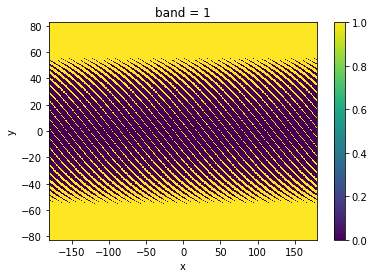

In [20]:
with gw.open('/Users/Admin/Documents/jordan/wrs2_descending/wrs2_descending_overlaps_grid.tif') as data:
    data.sel(band=1).plot.imshow()

In [6]:
from geowombat.core.util import rasterize_geometry

all_touched = False
frac = 0.1

# gdal_rasterize -a values -l wrs2_descending_overlaps -a_nodata 0 -init 0 -tr 0.1 0.1 -tap -ot Byte -co TILED=YES -co COMPRESS=LZW wrs2_descending_overlaps.shp wrs2_descending_overlaps_grid.tif
with gw.open('/Users/Admin/Documents/jordan/wrs2_descending/wrs2_descending_overlaps_grid.tif') as data:

    print(da.unique(data.data).compute())
    
#     meta = data.gw.meta

#     dfrow = dfm.iloc[0]

#     point_df = rasterize_geometry(dfrow['values'],
#                                   dfrow.geometry,
#                                   dfm.crs,
#                                   data.res[0],
#                                   all_touched,
#                                   meta,
#                                   frac)

[0 1]


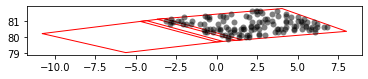

In [55]:
fig, ax = plt.subplots()

ax = dfm.iloc[:4].plot(color='none', edgecolor='red', ax=ax)
point_df.plot(c='k', edgecolor='white', lw=0.1, alpha=0.5, ax=ax)

In [15]:
dfm.sample?

In [10]:
dfm.to_file('/Users/Admin/Documents/jordan/wrs2_descending/wrs2_descending_overlaps.shp')

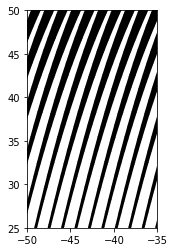

In [12]:
fig, ax = plt.subplots()

ax.set_xlim(-50, -35)
ax.set_ylim(25, 50)

# ax = dfa.plot(color='none', edgecolor='blue', ax=ax)
# ax = dfb.plot(color='none', edgecolor='red', ax=ax)
# ax = df.plot(color='none', edgecolor='red', ax=ax)
ax = dfm.plot(color='k', edgecolor='none', ax=ax)

## Download data

In [ ]:
gdl = GeoDownloads()

In [ ]:
import os
from datetime import datetime

rt = RadTransforms()
br = BRDF()

############
date_range = ['2004-10-01', '2005-05-01']
search_wildcards = ['ANG.txt', 'MTL.txt', 'B4.TIF', 'B8.TIF']
############

outdir = '/Users/Admin/Documents/jordan/imagery'
main_path = Path(outdir)
outdir_angles = main_path.joinpath('angles')
outdir_brdf = main_path.joinpath('brdf')
if not main_path.is_dir():
    main_path.mkdir()

if not outdir_angles.is_dir():
    outdir_angles.mkdir()

if not outdir_brdf.is_dir():
    outdir_brdf.mkdir()
    
gw_bin = os.path.realpath(os.path.dirname('/Users/Admin/Documents/jordan/scripts/Python/geowombat/geowombat/util/web.py'))
gw_bin = Path(gw_bin).joinpath('/../../bin')

sensors = ['l7', 'l8']

location = '225/083'

dt1 = datetime.strptime(date_range[0], '%Y-%m-%d')
dt2 = datetime.strptime(date_range[1], '%Y-%m-%d')

year = dt1.year
month = dt1.month

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

month_range = months[months.index(month):] + months[:months.index(dt2.month)+1]

m = month_range[0]

yearmonth_query = '{:d}{:02d}'.format(year, m)

sensor = sensors[0]

query = '{LOCATION}/*{PATHROW}_{YM}*_T*'.format(LOCATION=location,
                                                PATHROW=location.replace('/', ''),
                                                YM=yearmonth_query)

gdl.list_gcp(sensor, query)

if sensor.lower() != 's2':

    del_keys = [k for k, v in gdl.search_dict.items() if 'gap_mask' in k]

    for dk in del_keys:
        del gdl.search_dict[dk]
        
file_info = gdl.download_gcp(sensor,
                             outdir=outdir,
                             search_wildcards=search_wildcards,
                             verbose=1)

for finfo_key, finfo_dict in file_info.items():
    
    meta = rt.get_landsat_coefficients(finfo_dict['meta'].name)

#     angle_info = landsat_pixel_angles(finfo_dict['angle'].name,
#                                       finfo_dict['B8'].name,
#                                       outdir_angles.as_posix(),
#                                       meta.sensor,
#                                       l57_angles_path=gw_bin.joinpath('/ESPA/landsat_angles').as_posix(),
#                                       l8_angles_path=gw_bin.joinpath('/ESPA/l8_angles').as_posix(),
#                                       verbose=1)

    


## Landsat (ETM+)

In [ ]:
gdl.list_gcp('l7', '225/083/*225083_201901*_T*')

del_keys = [k for k, v in gdl.search_dict.items() if 'gap_mask' in k]

for dk in del_keys:
    del gdl.search_dict[dk]

In [ ]:
list(gdl.search_dict.keys())

In [ ]:
gdl.search_dict['LE07/01/225/083/LE07_L1TP_225083_20190208_20190306_01_T1']

In [ ]:
search_wildcards = ['ANG.txt', 'MTL.txt', 'B8.TIF']
outdir = '/Users/Admin/Documents/jordan/imagery'
p = Path(outdir)

In [ ]:
file_info = gdl.download_gcp('l7',
                             outdir=outdir, 
                             downloads='LE07/01/225/083/LE07_L1TP_225083_20190208_20190306_01_T1',
                             search_wildcards=search_wildcards,
                             verbose=1)

In [ ]:
with gw.config.update():

    with gw.open(p.joinpath('LE07_L1TP_225083_20190208_20190306_01_T1_B8.TIF').as_posix(),
                 band_names=['pan']) as ds:
        print(ds)
        #ds.gw.imshow(band_names='pan')
        ds.sel(band='pan')[5000:6000, 5000:6000].plot.imshow(robust=True)

## Landsat (OLI TIRS)

#### 2018

In [ ]:
gdl.list_gcp('l8', '225/083/*225083_201809*_T*')

In [ ]:
list(gdl.search_dict.keys())

#### 2019

In [ ]:
gdl.list_gcp('l8', '225/083/*225083_2019*_T*')

In [ ]:
list(gdl.search_dict.keys())

In [ ]:
# gdl.search_dict['LC08/01/225/083/LC08_L1TP_225083_20190131_20190206_01_T1']

In [ ]:
gdl.search_dict['LC08/01/225/083/LC08_L1TP_225083_20180909_20180912_01_T1']

In [ ]:
file_info = gdl.download_gcp('l8',
                             outdir=outdir, 
                             downloads='LC08/01/225/083/LC08_L1TP_225083_20180909_20180912_01_T1',
                             search_wildcards=search_wildcards,
                             verbose=1)

In [ ]:
search_wildcards = ['ANG.txt', 'MTL.txt', 'B2.TIF', 'B3.TIF', 'B4.TIF', 'B5.TIF']
outdir = '/media/jcgr/data/imagery/google/p225r083/downloads'

In [ ]:
file_info = gdl.download_gcp('l8',
                             outdir=outdir, 
                             search_wildcards=search_wildcards,
                             verbose=1)

In [ ]:
# file_info

## DN -> SR -> BRDF

In [ ]:
rt = RadTransforms()
br = BRDF()

In [ ]:
outdir_angles = p.joinpath('angles')
outdir_brdf = p.joinpath('brdf')
gw_bin = Path('/Users/Admin/Documents/jordan/scripts/Python/geowombat/geowombat/bin')

In [ ]:
os.path.realpath(__file__)

In [ ]:
angle_infos = dict()

kwargs = dict(readxsize=1024, 
              readysize=1024,
              verbose=1,
              separate=False,
              n_workers=1, 
              n_threads=8,
              n_chunks=100,
              overwrite=False)

In [ ]:
file_info

In [ ]:
for finfo_key, finfo_dict in file_info.items():
    
#     if 'LC08_L1TP_225083_20190216_20190222_01_T1' not in finfo_key:
#         continue

    meta = rt.get_landsat_coefficients(finfo_dict['meta'].name)
    
    angle_info = landsat_pixel_angles(finfo_dict['angle'].name, 
                                      finfo_dict['B8'].name, 
                                      outdir_angles.as_posix(), 
                                      meta.sensor, 
                                      l57_angles_path=gw_bin.joinpath('/ESPA/landsat_angles').as_posix(), 
                                      l8_angles_path=gw_bin.joinpath('/ESPA/l8_angles').as_posix(),
                                      verbose=1)
    
    out_dn = outdir_brdf.joinpath(Path(finfo_key).name + '_dn.tif').as_posix()
    out_sr = outdir_brdf.joinpath(Path(finfo_key).name + '_sr.tif').as_posix()
    out_brdf = outdir_brdf.joinpath(Path(finfo_key).name + '.tif').as_posix()
    break
    #with gw.config.update(ref_res=(100, 100)):

    with gw.open(angle_info.sza) as sza, gw.open(angle_info.vza) as vza, gw.open(angle_info.saa) as saa, gw.open(angle_info.vaa) as vaa:

        with gw.open([finfo_dict['B2'].name, 
                      finfo_dict['B3'].name, 
                      finfo_dict['B4'].name, 
                      finfo_dict['B5'].name], 
                     band_names=['blue', 'green', 'red', 'nir'],
                     stack_dim='band') as dn:

            #dn.gw.to_raster(out_dn, **kwargs)    

            # Convert DN to surface reflectance
            dn_sr = rt.dn_to_sr(dn, 
                                sza, saa, vza, vaa, 
                                sensor=meta.sensor, 
                                meta=meta)

            #dn_sr.gw.to_raster(out_sr, **kwargs)

            # BRDF normalization
            dn_sr_brdf = br.norm_brdf(dn_sr, 
                                      sza, saa, vza, vaa, 
                                      sensor=meta.sensor, 
                                      wavelengths=dn.band.values.tolist(), 
                                      nodata=0)

            dn_sr_brdf.gw.to_raster(out_brdf, **kwargs)    

    angle_infos[finfo_key] = angle_info

In [ ]:
for finfo_key, finfo_dict in file_info.items():
    
    out_brdf = Path(outdir_brdf).joinpath(Path(finfo_key).name + '.tif').as_posix()
    
    out_brdf_ovr = out_brdf + '.ovr'
    
    if not Path(out_brdf_ovr).is_file():

        print(out_brdf)

        com = 'gdaladdo -ro {} 2 4 8 16'.format(out_brdf)
        subprocess.call(com, shell=True)

## Get coefficients from metadata

In [ ]:
rt = RadTransforms()

meta = rt.get_landsat_coefficients('/Users/Admin/Documents/jordan/imagery/LE07_L1GT_225083_20190107_20190204_01_T2_MTL.txt')

In [ ]:
meta

In [ ]:
rt = RadTransforms()

# meta = rt.get_coefficients(file_info[1].name)
meta = rt.get_landsat_coefficients('/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_MTL.txt')

In [ ]:
meta

## Check data

In [ ]:
# with gw.open([file_info[2].name, file_info[3].name], 
#              band_names=['red', 'nir'],
#              stack_dim='band') as ds:
#     print(ds)
# #     ds.sel(band='nir').plot.imshow()

## Generate pixel angle files

In [ ]:
# angle_info = gw.gen_pixel_angles(file_info[0].name, 
#                                  file_info[2].name, 
#                                  '/media/jcgr/data/imagery/temp/google/angles', 
#                                  meta.sensor, 
#                                  l57_angles_path='/home/jcgr/Documents/scripts/Python/git_repos/geowombat/bin/ESPA/landsat_angles', 
#                                  l8_angles_path='/home/jcgr/Documents/scripts/Python/git_repos/geowombat/bin/ESPA/l8_angles',
#                                  verbose=1)

In [ ]:
# angle_info

In [ ]:
# with gw.open(angle_info.senze) as ds:
#     ds.sel(band=1).plot.imshow(robust=True)

In [ ]:
with gw.open(angle_info.senaz) as ds:
    ds.sel(band=1).plot.imshow(robust=True)

In [ ]:
with gw.open(angle_info.solaz) as solaz:
    with gw.open(angle_info.senaz) as senaz:
        rel_azimuth_angle = xr.ufuncs.fabs(solaz - senaz - 180.0)
        rel_azimuth_angle.sel(band=1).plot.imshow(robust=True)

## Convert to surface reflectance

In [ ]:
angle_info

In [ ]:
# with gw.open(angle_info.sze) as sze:
#     with gw.open(angle_info.vze) as vze:
#         with gw.open(angle_info.saa) as saa:
#             with gw.open(angle_info.vaa) as vaa:
#                 with gw.open([file_info[2].name, file_info[3].name], 
#                              band_names=['red', 'nir'],
#                              stack_dim='band') as dn:

kwargs = dict(readxsize=1024, 
              readysize=1024, 
              n_workers=1, 
              n_threads=4,
              n_chunks=100,
              overwrite=True)

with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_zenith.tif', chunks=512) as sze:
    with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_zenith.tif', chunks=512) as vze:
        with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_solar_azimuth.tif', chunks=512) as saa:
            with gw.open('/media/jcgr/data/imagery/temp/google/angles/LC08_L1TP_042034_20160121_20170224_01_T1_sensor_azimuth.tif', chunks=512) as vaa:                
                
                with gw.open(['/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B4.TIF', 
                              '/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B5.TIF',
                              '/media/jcgr/data/imagery/temp/google/LC08_L1TP_042034_20160121_20170224_01_T1_B6.TIF'], 
                             band_names=['red', 'nir', 'swir1'],
                             stack_dim='band',
                             chunks=512) as dn:
                    
#                     dn.gw.to_raster('/media/jcgr/data/imagery/temp/google/dn.tif', **kwargs)

                    # Convert DN to surface reflectance
                    dn_sr = rt.dn_to_sr(dn, sze, saa, vze, vaa, sensor=meta.sensor, meta=meta)
                    
#                     dn_sr.gw.to_raster('/media/jcgr/data/imagery/temp/google/dn_sr.tif', **kwargs)
                    
                    # BRDF normalization
                    dn_sr_brdf = BRDF().norm_brdf(dn_sr, sze, saa, vze, vaa, sensor=meta.sensor, wavelengths=dn.band.values.tolist(), nodata=0)
                    
#                     dn_sr_brdf.gw.to_raster('/media/jcgr/data/imagery/temp/google/dn_sr_brdf.tif', **kwargs)

In [ ]:
dn_sr

In [ ]:
dn_sr_brdf

In [ ]:
dn.sel(band='nir').plot.imshow(robust=True)

In [ ]:
dn_sr.sel(band='nir').plot.imshow(robust=True)

In [ ]:
dn_sr_brdf.sel(band='nir').plot.imshow(robust=True)